# **Preprocesado completo de las curvas de luz**: estrella KIC 2696703

En este documento se explica paso a paso el preprocesado de una curva de luz (KIC 2696703) hasta el output final, que será una versión simplificada de la curva y de su(s) tránsito(s). Comenzamos cargando las librerías necesarias:

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import lightkurve as lk
import numpy as np
from wotan import transit_mask, flatten
%matplotlib inline

## Descarga, unión y centrado de la curva de luz

Empleando la función `search_lightcurve()` del paquete `{lightkurve}` podemos acceder a la descarga a través del MAST (Mikulski Archive for Space Telescopes) de cualquier curva de luz en periodos cuatrimestrales. Descarguemos para esta prueba todos los cuatrimestres de la estrella KIC 2696703.

In [56]:
lc = lk.search_lightcurve('KIC 5002361', author='Kepler', cadence='long').download_all()

Si graficamos el objeto `lc` podremos observar la curva de luz completa de KIC 2696703 en su forma primigenia. Disponemos en este caso de 17 cuatrimestres cada uno de ellos en una escala diferente. Además se pueden observar saltos temporales en los que no existe información acerca del flujo lumínico de la estrella. Estos periodos se consideran valores ausentes y ocurrieron como consecuencia de la reconfiguración cuatrimestral de los filtros de banda de paso del satélite Kepler durante sus años de actividad.

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

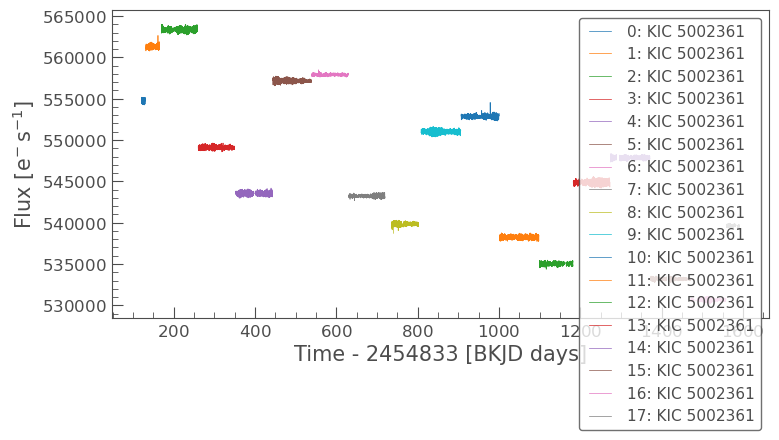

In [57]:
lc.plot()

Con la función `stitch()` podemos agrupar todos los cuatrimestres en una única serie. El output hace referencia al total de puntos de información que disponemos para esta estrella: 65 504.

In [58]:
lc_base = lc.stitch()
lc_base.flux.shape

(65504,)

Si se atiende al eje y, podremos percatarnos de que la función `stitch()` -que hemos aplicado en el chunk anterior- centra automáticamente todos los cuatrimestres alrededor del valor 1 al dividir cada cuatrimestre por su mediana. De esta manera tenemos ya agrupados en un único eje todos los cuatrimestres. Esta sería la configuración inicial de cada curva de luz sobre la cual comenzaría la fase de depuración y preprocesado. 

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

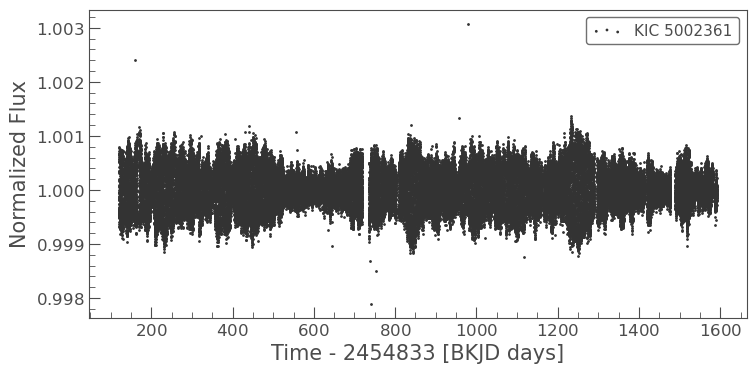

In [59]:
lc_base.scatter()

## Eliminación de valores outliers

En esta segunda fase eliminaremos los valores outliers de la curva de luz, aunque únicamente aquellos que superan en $\sigma$ veces el valor medio de la propia curva. Estos valores por encima de la curva son atribuibles a rayos cósmicos, erupciones estelares que incrementan temporalmente el flujo lumínico, o, incluso a errores en el propio sensor del satélite. En este sentido, a la hora de identificar posibles tránsitos, lo único que merece interés son las disminuciones en la actividad lumínica de la estrella, disminuciones que puedan coincidir con el paso de un exoplaneta frente a los sensores del satélite.

Para la eliminación de estos valores, emplearemos la función `remove_outliers()` que permite definir un valor $\sigma$ a partir del cual trabajar. En nuestro caso emplearemos un valor de 20 $\sigma$ y un límite superior de 4 $\sigma$. Estos valores son los habituales dentro de la literatura y permiten capturar y eliminar sin dificultad todos los valores que superen en 4 veces la desviación estándar de la curva.

In [60]:
lc_limpio = lc_base.remove_outliers(sigma=20, sigma_upper=4)

Como se puede observar en el gráfico, la gran mayoría de valores por encima de la curva han desaparecido.

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

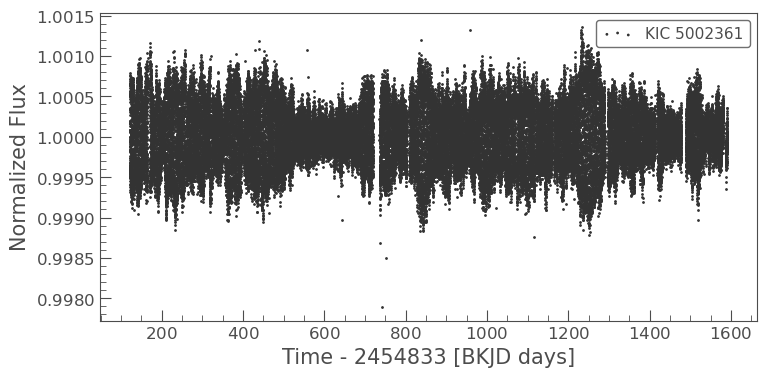

In [61]:
lc_limpio.scatter()

## Eliminación de la tendencia e interpolación de los TCEs

En esta tercera fase, eliminaremos la tendencia natural de las curvas de luz a fin de poder identificar más fácilmente los descensos en el flujo luminoso de las series (TCEs). *Grosso modo*, lo que se pretende realizar en esta sección es, mediante la creación de un spline polinomial, eliminar la variación natural de la curva sin que el propio spline se vea afectado por el descenso provocado por los TCEs. En este sentido, lo que se hará en primer lugar será enmascarar temporalmente los tránsitos que presente la estrella (disminuciones en el flujo lumínico) para después interpolarlos una vez aplicado el spline. 

Para llevar a cabo este proceso, se requiere almacenar en primera instancia información propia sobre los tránsitos de la estrella analizada. Esta información es la que recabamos del NASA Exoplanet Archive y que consistía fundamentalmente en tres variables:

1. **tce_period**: En días, el periodo orbital del TCE.
2. **tce_time0bk**: En Días Julianos Baricéntricos (BJD) menos un desplazamiento constante de 2.454.833,0 días, el instante temporal en el que se produce el mínimo del TCE.
3. **tce_duration**: En horas, la duración del TCE.

Para el caso que nos ocupa, y según el dataset extraido del NASA Exoplanet Archive, la estrella KIC 2696703 presenta un único TCE con $P=6.094050$ días, $T_0=133.660$ días, y una duración del tránsito de $1.8100$ horas. Almacenamos esta información en variables:

In [62]:
period, t0, duration_hours, duration = 0.536091, 131.629, 1.7810, 1.7810 / 24

A la hora de enmascarar los posibles TCEs de la estrella a analizar, emplearemos esta información para identificar las partes de la curva que deben ser interpoladas. Lo primero que haremos será extraer la información del tiempo y del flujo lumínico una vez eliminados los valores outliers. Guardaremos la información en dos nuevas variables como arrays.

In [63]:
time = lc_limpio['time'].value
flux = lc_limpio['flux']
flux =np.array(flux)

Tras ello, generaremos la máscara con el tránsito que se está analizando. Para ello nos serviremos de la función `transit_mask()` del paquete `{wotan}`. Esta función nos permite generar una matriz booleana con True durante el periodo del tránsito y False en el resto de instantes temporales. Usaremos esta matriz para enmascarar los valores True e interpolarlos una vez se haya eliminado la tendencia de la curva a través del spline. El cálculo de la matriz se realiza en base al periodo orbital, al tc0 y a la duración del propio TCE, información que deberemos proveer a la función como atributos.

In [64]:
mask = transit_mask(
    time=time,
    period=period,
    duration=duration,
    T0=t0)

Una vez llevado a cabo todo este proceso, podemos proceder a eliminar la tendencia de la curva. Para ello, emplearemos la función `flatten()` del paquete `wotan()` añadiendo el atributo `mask()` con la matriz booleana generada. Los valores del flujo lumínico en donde la matriz sea True no se utilizarán para aplanar la curva. Una vez finaliza el proceso de aplanado, la función interpola automáticamente esos puntos.

A parte del atributo `mask()`, también deberemos indicarle a la función otros cuatro atributos: el método, la venta temporal sobre la que se reajusta el spline (3 veces la duración del TCE), los valores del propio spline, y el atributo `robust`. Este último permite ir eliminando valores outliers considerados en cada iteración.

In [65]:
flatten_lc, trend_lc = flatten(
    time,
    flux,
    method='cosine',
    window_length=duration * 3,
    return_trend=True,
    robust=True,
    mask=mask)

Iteration: 1 Rejected outliers (total): 10
Iteration: 2 Rejected outliers (total): 13
Iteration: 3 Rejected outliers (total): 14
Iteration: 4 Rejected outliers (total): 15
Converged.
Iteration: 1 Rejected outliers (total): 27
Iteration: 2 Rejected outliers (total): 30
Iteration: 3 Rejected outliers (total): 31
Converged.
Iteration: 1 Rejected outliers (total): 3
Converged.
Iteration: 1 Rejected outliers (total): 53
Iteration: 2 Rejected outliers (total): 59
Iteration: 3 Rejected outliers (total): 58
Converged.
Iteration: 1 Rejected outliers (total): 2
Converged.
Iteration: 1 Rejected outliers (total): 22
Iteration: 2 Rejected outliers (total): 26
Converged.
Iteration: 1 Rejected outliers (total): 0
Converged.
Iteration: 1 Rejected outliers (total): 0
Converged.
Iteration: 1 Rejected outliers (total): 16
Iteration: 2 Rejected outliers (total): 24
Converged.
Iteration: 1 Rejected outliers (total): 5
Iteration: 2 Rejected outliers (total): 7
Iteration: 3 Rejected outliers (total): 9
Conve

Tras ejecutar la función, guardamos los resultados en nuestro dataframe original, sustituyendo los valores del flujo y añadiendo la tendencia del spline.

In [66]:
lc_limpio['flux'] = flatten_lc
lc_limpio['trend_lc'] = trend_lc
lc_final = lc_limpio

Y a continuación el gráfico con la curva ya aplanada y con los TCEs interpolados.

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

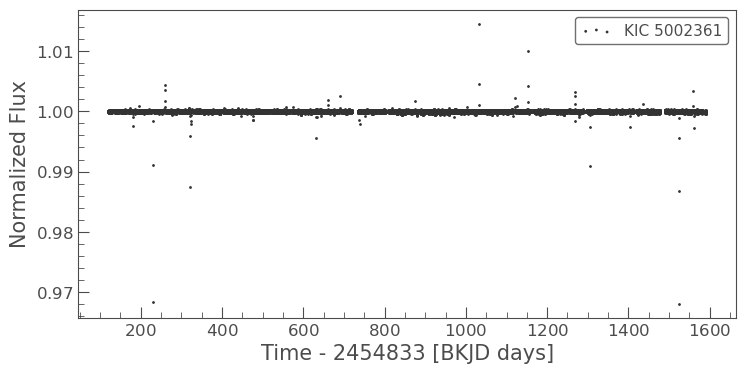

In [67]:
lc_final.scatter()

Si nos acercamos al tránsito de alguno de los TCE podremos apreciar de mejor manera el aplanamiento de la curva. En los gráficos subsiguientes se muestra el antes y el después.

(0.98, 1.07)

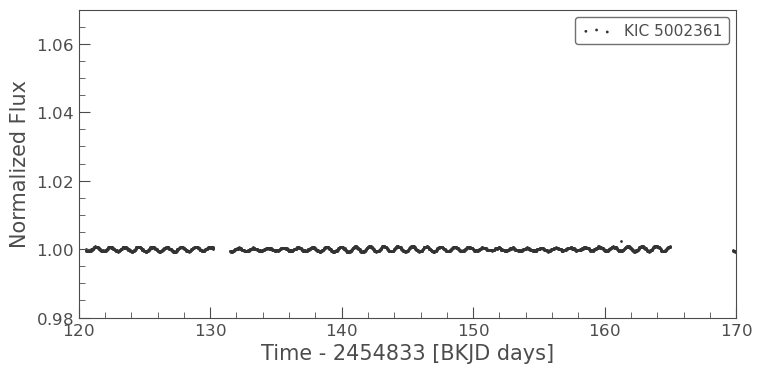

In [68]:
ax = lc_base.scatter()
ax.set_xlim(120, 170)
ax.set_ylim(0.98, 1.07)

(0.98, 1.07)

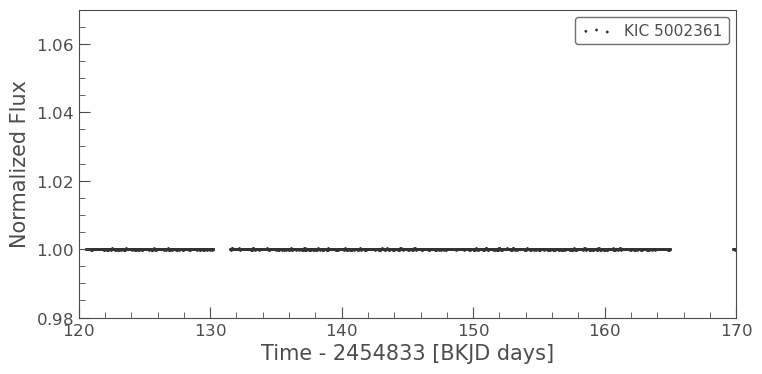

In [69]:
ax = lc_final.scatter()
ax.set_xlim(120, 170)
ax.set_ylim(0.98, 1.07)

## Creación de la versión *phase-fold* de la curva

En este pequeño apartado crearemos la versión *phase-fold* de la curva una vez aplanda y sin valores outliers. En esencia, el *phase-folding* consiste en tomar una curva de luz y doblarla en un patrón periódico para que la señal parezca repetirse a lo largo de un ciclo completo. Esto se logra dividiendo el tiempo por el período de la señal, lo que da como resultado un valor conocido como "fase".

El *phase-folding* es útil porque permite visualizar patrones en los datos que no son evidentes cuando se representan en el tiempo. Por ejemplo, si se está observando una estrella variable, es posible que la curva de luz no muestre un patrón claro si se grafica en función del tiempo, pero cuando se realiza el *phase-folding* con el período concreto de la estrella, el patrón del posible tránsito o TCE se hace evidente porque queda centrado en el instante temporal 0.

En nuestro caso nos serviremos de la función `fold()` a la que únicamente habrá que introducir dos atributos: el periodo orbital del TCE y su mínimo (`epoch_time`).

In [70]:
lc_fold = lc_final.fold(period=period, epoch_time=t0)

A continuación se muestra la versión *phase-fold* de la curva de luz ya procesada. Como se puede observar, el TCE analizado se encuentra centrado. 

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

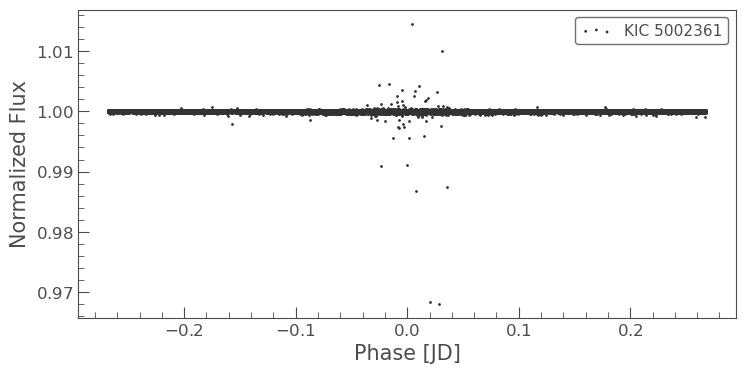

In [71]:
lc_fold.scatter()

Esta sería la versión final de la curva de luz para el TCE analizado. Las curvas de luz tendrán tantas versiones *phase-fold* como posibles TCEs identificados. Recordemos que cada TCE viene indexado en el archivo proveído por el NASA Exoplanet Archive. 

Además, volvemos a filtrar los outliers por encima de la curva, ya que algunos, en ciertas ocasiones, persisten al aplanado.

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

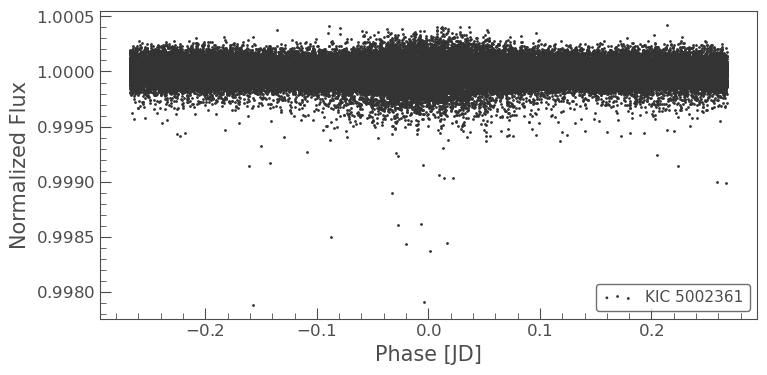

In [72]:
lc_fold = lc_fold.remove_outliers(sigma=20, sigma_upper=4)
lc_fold.scatter()

## Creación de los inputs finales: visión global y local del TCE

Para finalizar, generaremos dos visiones, una general y otra localizada, de cada TCE. Estas dos visiones servirán como input para los modelos que posteriormente queramos entrenar. 

### Visión general

In [73]:
lc_global = lc_fold.bin(n_bins=2001, time_bin_size=1/2001 * period, time_bin_start=-period/2).normalize() - 1
lc_global = (lc_global / np.abs(lc_global.flux.min()))
lc_global.flux.shape

(2001,)

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

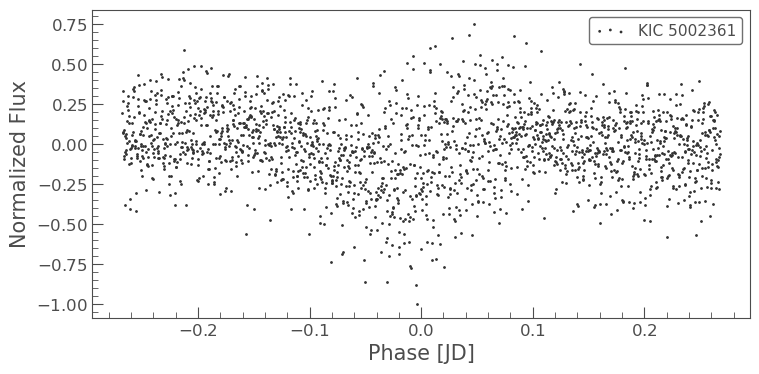

In [74]:
lc_global.scatter()

En nuestro ejemplo, la visión global se ve muy debilitada principalmente porque el periodo orbital del TCE identificado es muy amplio (de más de 300 días). En nuestra curva de luz, el TCE se repetía en tan solo 3 ocasiones. Ello provoca que, cuando generamos la versión *phase-folded* de la curva de luz, el tránsito se vea muy poco reforzado. Recordemos que al «doblar» la curva lo que hacemos es solapar los tránsitos sobre un único instante temporal. Si solo tenemos 3 repeticiones del tránsito, la versión final quedará muy simplificada.

### Visión localizada

In [75]:
phase_mask = (lc_fold.phase > max(-period / 2, -duration * 4)) & (lc_fold.phase < min(period / 2, duration * 4))
lc_zoom = lc_fold[phase_mask]

In [76]:
lc_local = lc_zoom.bin(n_bins=201, time_bin_size=0.05 * duration).normalize() - 1
lc_local = (lc_local / np.abs(np.nanmin(lc_local.flux)))
lc_local.flux.shape

(201,)

Y aquí la visión local, mucho más cercana al propio TCE:

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

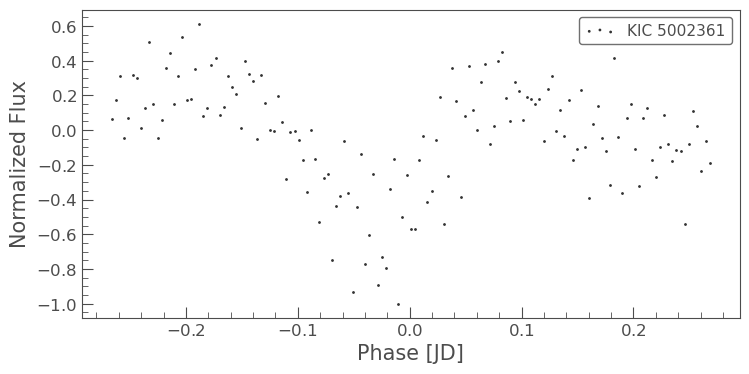

In [77]:
lc_local.scatter()

In [79]:
lc_local.to_csv("local_imple.csv", overwrite=True)